In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as img
from skimage import color, data, restoration
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as ss
import time
from numba import jit
from scipy.spatial.distance import cdist
from scipy.signal import convolve2d as conv2

We will begin by working with the following image of a checkerboard

In [2]:
im = img.imread('ortonStripes.jpg')
imbw = 0.2126*im[:,:,0] + 0.7152*im[:,:,1] + 0.0722*im[:,:,2]

In [3]:
imbw2 = imbw.copy()
#imbw = imbw2[40:60,40:60]

Text(0.5, 1.0, '20 x 20 Stripes')

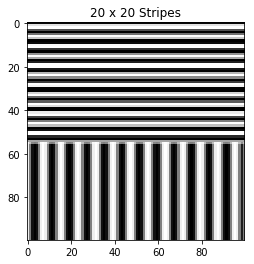

In [4]:
plt.figure()
plt.imshow(imbw,cmap='gray') #Black and White Image 
plt.title('20 x 20 Stripes')

Lets try to blur this image using a Gaussian Blur Kernel

We will first try a Gaussian Blur, which uses a 2D Gaussian Kernel. We will assume that this is a circular Gaussian.

The continuous point spread function with standard deviation
$$
f(x,y) = \frac{1}{2 \pi \sigma^2} \exp \left (   -\frac{1}{2}(x - \mu)^2 - \frac{1}{2}(y - \mu)^2) \right )
$$
When discretizing this distribution, we choose the interval to span 2 standard deviations in each direction. Additionally, we must choose how many pixels this kernel will integrate over, which will be determined by the size of the discretization

In this demo, we will try this with $\mu = 0$ and $\sigma^2 = 1$

In [5]:
@jit #Numba jit compiler
def circular_gaussian(mean,sigma,kdim):
    x = np.linspace(-2*sigma,2*sigma,kdim)
    y = np.linspace(-2*sigma,2*sigma,kdim)
    xx,yy = np.meshgrid(x,y)
    kernel = (1/(2*np.pi*sigma**2))*np.exp(-0.5*np.power((xx-mean)/sigma,2) - 0.5*np.power((yy-mean)/sigma,2))
    kernel = kernel/np.sum(kernel) #Normalize Kernel
    return xx,yy,kernel

In [7]:
sigma = 1
var = sigma**2
kdim = 15
xx, yy, kernel = circular_gaussian(mean = 0,sigma = sigma,kdim = kdim)
#kernel += np.random.normal(0.01,0.001,kernel.shape)

Text(0.5, 0, '$z$')

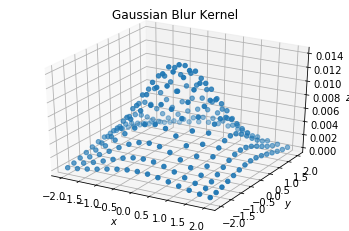

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(xx,yy,kernel,cmap='gray')
plt.title("Gaussian Blur Kernel")
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.set_zlabel('$z$')
#fig.savefig("Gaussian.png",dpi=800)

In [9]:
imconv = ss.convolve2d(imbw,kernel) #Convolved image

(-0.5, 113.5, 113.5, -0.5)

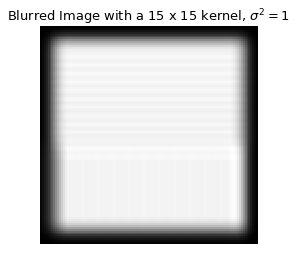

In [10]:
plt.figure()
plt.imshow(imconv,cmap='gray') 
plt.title("Blurred Image with a %d x %d kernel, $\sigma^2 = %d$"%(kdim,kdim,var),fontsize=13)
plt.axis('off')

Our goal is to implement the 2-Dimensional Richardson Algorithm, which I will show an explanation of here

Given a degraded image, $H$, of size $N \times M$, and a (normalized) blurring kernel $S$, which is of size $K \times K$, we will need to recover the original image $W$, which must be of size $(N-K+1) \times (M - K +1)$. 

We will treat $H,S,W$ as probabilities using the normalization $P(W_{ij}) = \frac{W_{ij}}{\sum \limits_{n,m}W_{nm}}$ 

By Bayes' Theorem
\begin{align*}
P(W_{ij} | H_{nm}) &= \frac{P(H_{nm}|W_{ij})}{\sum \limits_{k,l}P(H_{nm} |W_{kl}) \cdot P(W_{kl})}
\end{align*}

Also

$$
P(W_i) = \sum \limits_{n,m} P(W_{ij}|H_{nm})\cdot P(H_{nm})
$$

Substituting in for $P(W_{ij} | H_{nm})$, we see that 

$$
P(W_{ij}) = \sum \limits_{n=0}^{N-1} \sum \limits_{m=0}^{M-1} \frac{P(H_{nm} | W_{ij}) P(H_{nm}) P(W_{ij})}{ \sum \limits_{\ell = 0}^{I-1} \sum \limits_{k=0}^{J-1} P(H_{nm}|W_{\ell k}) \cdot P(W_{\ell k})}
$$



\begin{align*}
W_{ij,r+1} &= W_{ij,r} \sum \limits_{n=i}^{N-1} \sum \limits_{m=j}^{M-1} \frac{S_{n-i,m-j} H_{nm} }{ \sum \limits_{\ell = 0}^{I-1} \sum \limits_{k=0}^{J-1} S_{n-\ell,m-k}  W_{\ell k,r}}
\end{align*}

Notice that the denominator is simply $S * W_r$. Let $S^{T}$ denote the transpose of $S$. Then

$$W_{r+1} = W_{r}\cdot \left (S^{T} * \frac{H}{S*W_r} \right ).$$
This is the iteration we will compute

In [17]:
#My function
def Richardson_Iteration(H,kernel,num_its,convolve_method = 0):
    #If convolve_method = 0, we will use the FFT Method
    #Otherwise we will use the normal 2d convolve
    #First compute parameters
    S = kernel #makes life easier
    (N,M) = H.shape #Dimensions of the degraded image
    K,L = S.shape #Size of the Kernel
    I = N - K + 1 # Dimensions of the original image
    J = M - K + 1
    II = np.sum(H) # Total energy of degraded image
    W = .5*np.ones((N,M,num_its)) #This will force the initial condition as the first iteration
    for r in range(num_its-1):
        if convolve_method == 0: 
            temp0 = H/ss.fftconvolve(W[:,:,r],kernel,'same')
            temp1 = ss.fftconvolve(temp0,S[::-1,::-1],'same') #Reverse the Kernel
            W[:,:,r+1] = W[:,:,r]*temp1
        
        else:
            temp0 = H/ss.convolve2d(W[:,:,r],kernel,'same')
            temp1 = ss.convolve2d(temp0,S[::-1,::-1],'same') #Reverse the Kernel
            W[:,:,r+1] = W[:,:,r]*temp1
    return W

In [18]:
#Faster Function, Does not store each iteration
def Richardson_Iteration2(H,kernel,num_its,convolve_method = 0):
    #If convolve_method = 0, we will use the FFT Method
    #Otherwise we will use the normal 2d convolve
    #First compute parameters
    S = kernel #makes life easier
    (N,M) = H.shape #Dimensions of the degraded image
    K,L = S.shape #Size of the Kernel
    I = N - K + 1 # Dimensions of the original image
    J = M - K + 1
    II = np.sum(H) # Total energy of degraded image
    W = .5*np.ones((N,M)) #This will force the initial condition as the first iteration
    if convolve_method == 0:
        
        for r in range(num_its):
            temp0 = H/ss.fftconvolve(W,kernel,'same')
            temp1 = ss.fftconvolve(temp0,S[::-1,::-1],'same') #Reverse the Kernel
            W = W * temp1
        
    else:
        for r in range(num_its):
            temp0 = H/ss.convolve2d(W,kernel,'same')
            temp1 = ss.convolve2d(temp0,S[::-1,::-1],'same') #Reverse the Kernel
            W = W*temp1
    return W

In [19]:
#Parameters
num_its = 2000

In [20]:
#%%timeit # Uncomment to time the iteration
Wnew = Richardson_Iteration(imconv,kernel,num_its)

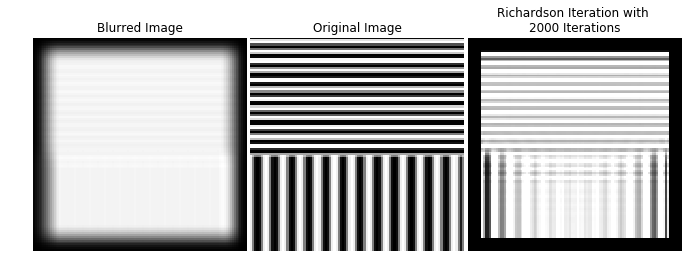

In [21]:
fig,ax = plt.subplots(1,3,figsize = (9,6))
for pl in ax:
    pl.axis('off')

ax[2].imshow(Wnew[:,:,-1],vmin = imconv.min(),vmax = imconv.max(),cmap='gray')
ax[2].set_title("Richardson Iteration with \n%d Iterations"%num_its)

ax[1].imshow(imbw,cmap='gray')
ax[1].set_title("Original Image")

ax[0].imshow(imconv,cmap='gray')
ax[0].set_title('Blurred Image')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)

Now to try this on a few images

In [22]:
#Image Functions
@jit
def im2bw(image): #Black and White Imag
    return 0.2126*image[:,:,0] + 0.7152*image[:,:,1] + 0.0722*image[:,:,2]
    
@jit
def blur_image(image,kdim,sigma=1): #Blurring Function
    xx,yy,kernel = circular_gaussian(0,sigma,kdim)
    return ss.fftconvolve(image,kernel),kernel

def blur_image_color(image,kdim,sigma=1): #Blurring Function
    xx,yy,kernel = circular_gaussian(0,sigma,kdim)
    n,m,l = image.shape
    blurred_image = np.empty((n + kdim - 1, m + kdim - 1, 3))
    blurred_image[:,:,0] = ss.fftconvolve(image[:,:,0],kernel)
    blurred_image[:,:,1] = ss.fftconvolve(image[:,:,1],kernel)
    blurred_image[:,:,2] = ss.fftconvolve(image[:,:,2],kernel)
    return blurred_image,kernel


def deblur_color(blurry,kernel,num_its): 
    W = np.empty(blurry.shape)
    W[:,:,0] = Richardson_Iteration(blurry[:,:,0],kernel,num_its)[:,:,-1]
    W[:,:,1] = Richardson_Iteration(blurry[:,:,1],kernel,num_its)[:,:,-1]
    W[:,:,2] = Richardson_Iteration(blurry[:,:,2],kernel,num_its)[:,:,-1]
    return W

def deblur_color2(blurry,kernel,num_its,method = 0): 
    W = np.empty(blurry.shape)
    W[:,:,0] = Richardson_Iteration2(blurry[:,:,0],kernel,num_its, convolve_method=method)
    W[:,:,1] = Richardson_Iteration2(blurry[:,:,1],kernel,num_its, convolve_method=method)
    W[:,:,2] = Richardson_Iteration2(blurry[:,:,2],kernel,num_its, convolve_method=method)
    return W

In [23]:
from scipy import misc 
f = im2bw(data.chelsea())

(-0.5, 450.5, 299.5, -0.5)

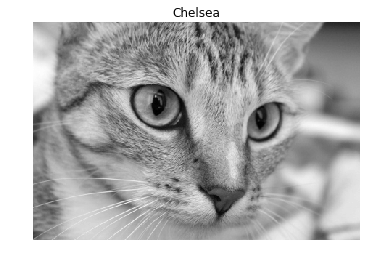

In [24]:
plt.figure()
plt.imshow(f,cmap='gray')
plt.title("Chelsea")
plt.axis('off')

(-0.5, 469.5, 318.5, -0.5)

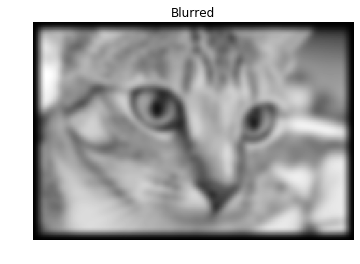

In [25]:
fblur,kernel2 = blur_image(f,20,sigma=2)
plt.figure()
plt.imshow(fblur,cmap='gray')
plt.title("Blurred")
plt.axis('off')

In [26]:
W = Richardson_Iteration(fblur,kernel2,200)

Text(0.5, 1.0, '200 Iterations')

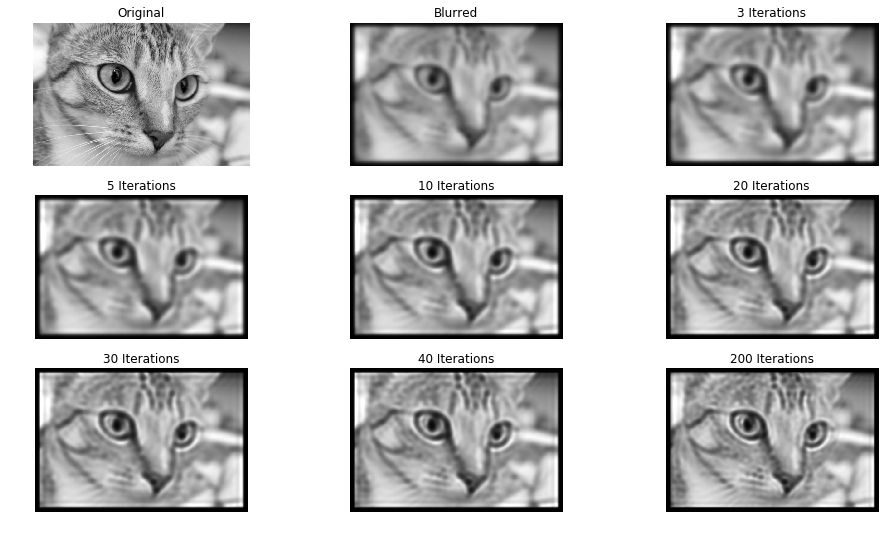

In [27]:
#Turns axis off 
fig,ax = plt.subplots(3,3,figsize = (16,9))
for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i,j].axis('off')
        
ax[0,0].imshow(f,cmap='gray')
ax[0,0].set_title("Original")

ax[0,1].imshow(fblur,cmap='gray')
ax[0,1].set_title("Blurred")

ax[0,2].imshow(W[:,:,3],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[0,2].set_title("3 Iterations")

ax[1,0].imshow(W[:,:,5],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[1,0].set_title("5 Iterations")

ax[1,1].imshow(W[:,:,10],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[1,1].set_title("10 Iterations")

ax[1,2].imshow(W[:,:,20],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[1,2].set_title("20 Iterations")

ax[2,0].imshow(W[:,:,30],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[2,0].set_title("30 Iterations")

ax[2,1].imshow(W[:,:,40],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[2,1].set_title("40 Iterations")

ax[2,2].imshow(W[:,:,-1],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[2,2].set_title("200 Iterations")

# fig.savefig('coons.png', dpi = 800)        

(-0.5, 469.5, 318.5, -0.5)

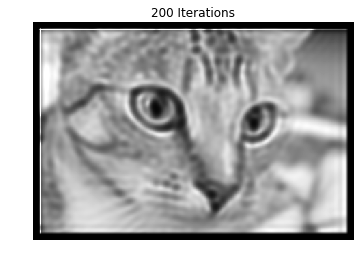

In [29]:
plt.figure()
plt.imshow(W[:,:,-1],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
plt.title("200 Iterations")
plt.axis('off')

In [28]:
fc = data.chelsea()

In [33]:
bi,kernel = blur_image_color(fc,20)

Text(0.5, 1.0, 'Chelsea with Color')

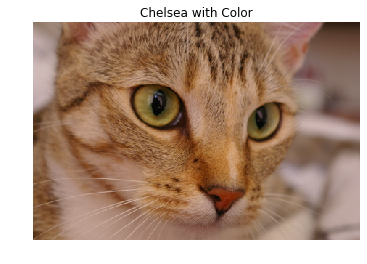

In [32]:
plt.figure()
plt.imshow(fc)
plt.axis('off')
plt.title("Chelsea with Color")

(-0.5, 469.5, 318.5, -0.5)

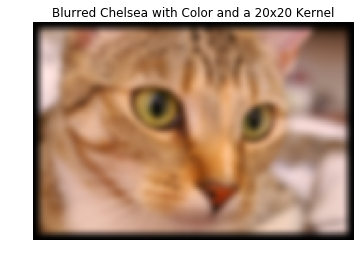

In [34]:
plt.figure()
plt.imshow(bi/np.max(bi))
plt.title("Blurred Chelsea with Color and a 20x20 Kernel")
plt.axis('off')

In [272]:
WW = deblur_color2(bi,kernel2,num_its = 100)

NameError: name 'WW' is not defined

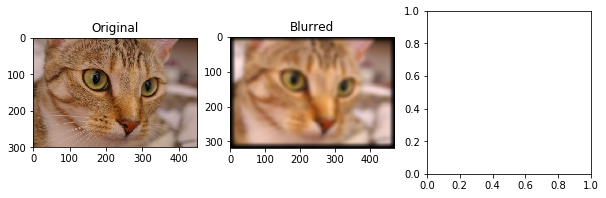

In [35]:
fig3,ax3 = plt.subplots(1,3,figsize = (10,3))
ax3[0].imshow(fc)
ax3[0].set_title("Original")
ax3[1].imshow(bi/np.max(bi))
ax3[1].set_title("Blurred")
ax3[2].imshow(WW/np.max(WW)) 
ax3[2].set_title("100 Iterations")
for ax in ax3:
    ax.axis('off')

In [37]:
Impulse = np.zeros((30,30))

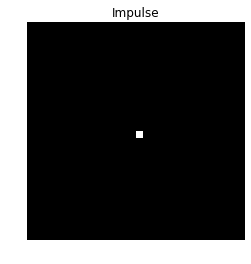

In [41]:
Impulse[15,15] = 255
plt.figure()
plt.imshow(Impulse,cmap = 'gray')
plt.title("Impulse")
plt.axis('off')
plt.axis('off')
plt.savefig('impulse1.eps',dpi=800)

In [42]:
Blurred_Impulse,kernel = blur_image(Impulse,kdim=5)

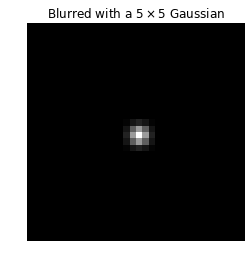

In [44]:
plt.figure()
plt.imshow(Blurred_Impulse,cmap='gray')
plt.axis('off')
plt.title("Blurred with a $5 \\times 5$ Gaussian")
plt.savefig('impulse_blurred.eps',dpi=800)

In [294]:
Recovered_Impulse = Richardson_Iteration(Blurred_Impulse,kernel,100,convolve_method=1)

(-0.5, 33.5, 33.5, -0.5)

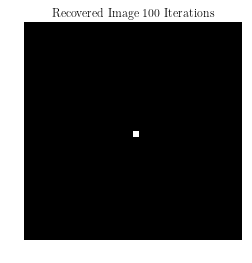

In [180]:
W2 = Recovered_Impulse[:,:,-1]
plt.figure()
plt.imshow(W2,cmap='gray')
plt.title("Recovered Image 100 Iterations")
plt.axis('off')

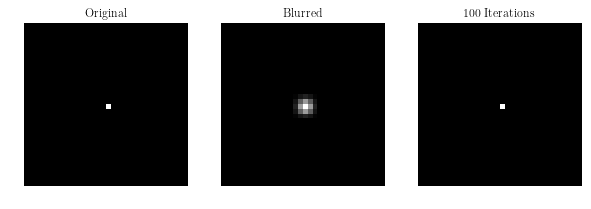

In [295]:
fig4,ax4 = plt.subplots(1,3,figsize = (10,3))
ax4[0].imshow(Impulse,cmap='gray')
ax4[0].set_title("Original")
ax4[1].imshow(Blurred_Impulse,cmap = 'gray')
ax4[1].set_title("Blurred")
ax4[2].imshow(Recovered_Impulse[:,:,-1],cmap='gray')
ax4[2].set_title("100 Iterations")
for ax in ax4:
    ax.axis('off')

In [296]:
sharpen = np.array([[0.5, -3, 0.5], [-3, 6, -3], [0.5, -3, 0.5]])

In [297]:
fsharp = ss.convolve2d(f,sharpen)

(-0.5, 450.5, 299.5, -0.5)

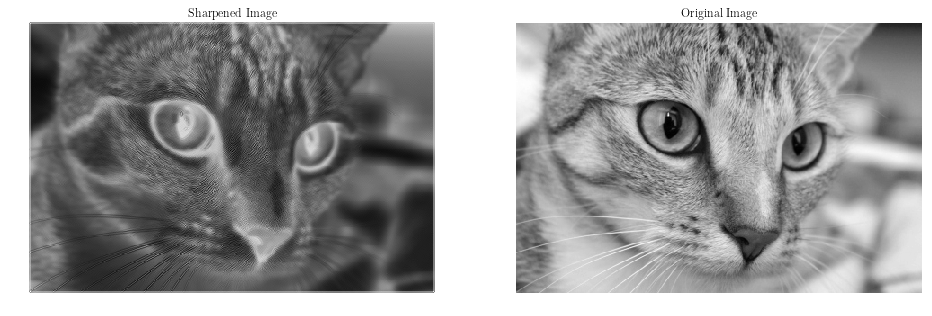

In [298]:
fig5, ax5 = plt.subplots(1,2, figsize = (16,9))
ax5[0].imshow(fsharp,cmap = 'gray')
ax5[0].set_title("Sharpened Image")
ax5[1].imshow(f,cmap='gray')
ax5[1].set_title("Original Image")
ax5[0].axis('off')
ax5[1].axis('off')


In [299]:
Ws = Richardson_Iteration2(fsharp,sharpen,50,convolve_method=1)

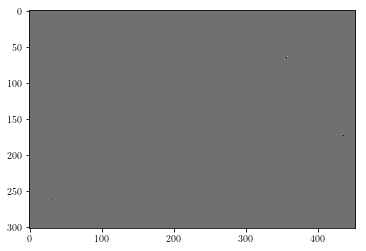

In [300]:
plt.figure()
plt.imshow(Ws)

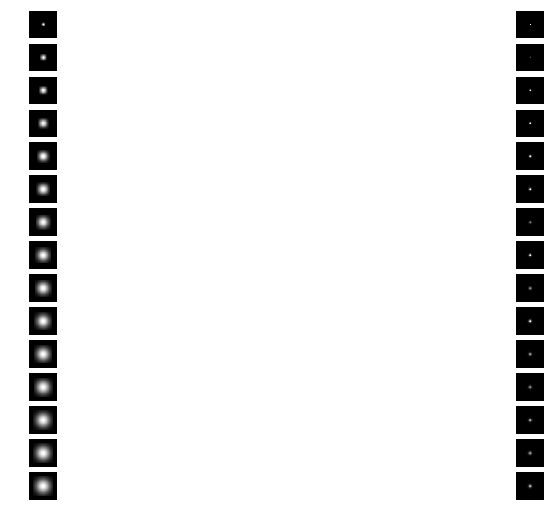

In [301]:
fig6,ax6 = plt.subplots(15,2, figsize= (16,9))
for i in range(5,80,5):
    Blurred_Impulse,kernel = blur_image(Impulse,kdim=i)
    Recovered_Impulse = Richardson_Iteration2(Blurred_Impulse,kernel,50,convolve_method=1)
    ax6[int(i/5) - 1,0].imshow(Blurred_Impulse)
    ax6[int(i/5)-1,0].axis('off')
    ax6[int(i/5)-1,1].imshow(Recovered_Impulse)
    ax6[int(i/5)-1,1].axis('off')
fig6.savefig("impulses2.png",dpi=800)


(-0.5, 469.5, 318.5, -0.5)

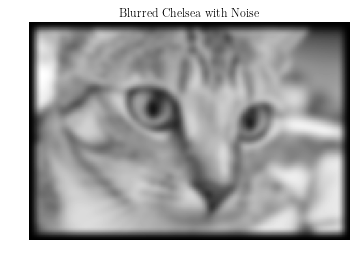

In [304]:
fblur2,kernel3 = blur_image(f,20,sigma=2)
plt.figure()
fblur2 = fblur2 + (np.random.poisson(lam=25, size=fblur2.shape) - 10) / 255.
plt.imshow(fblur2,cmap='gray')
plt.title("Blurred Chelsea with Noise")
plt.axis('off')

In [305]:
Wnoise = Richardson_Iteration(fblur,kernel3,200)

Text(0.5,1,'200 Iterations')

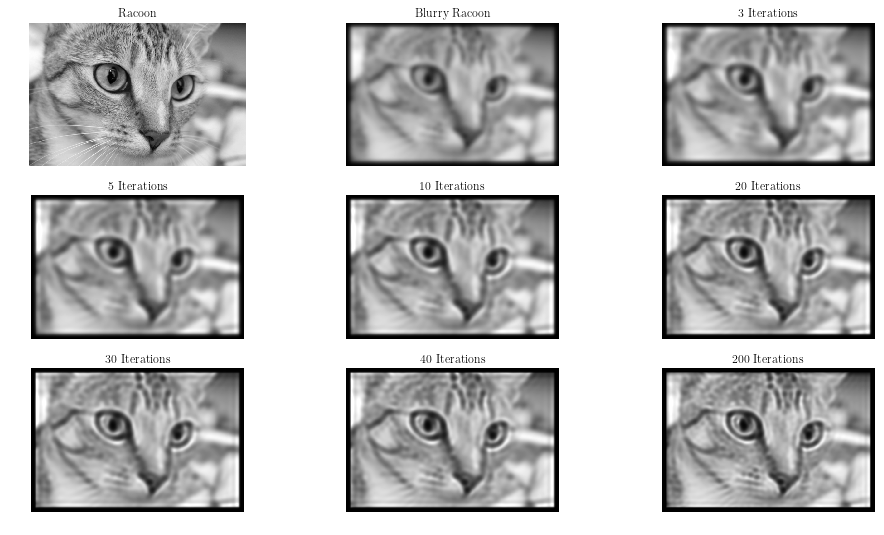

In [306]:
fig,ax = plt.subplots(3,3,figsize = (16,9))
for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i,j].axis('off')
        
ax[0,0].imshow(f,cmap='gray')
ax[0,0].set_title("Racoon")

ax[0,1].imshow(fblur,cmap='gray')
ax[0,1].set_title("Blurry Racoon")

ax[0,2].imshow(Wnoise[:,:,3],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[0,2].set_title("3 Iterations")

ax[1,0].imshow(Wnoise[:,:,5],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[1,0].set_title("5 Iterations")

ax[1,1].imshow(Wnoise[:,:,10],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[1,1].set_title("10 Iterations")

ax[1,2].imshow(Wnoise[:,:,20],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[1,2].set_title("20 Iterations")

ax[2,0].imshow(Wnoise[:,:,30],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[2,0].set_title("30 Iterations")

ax[2,1].imshow(W[:,:,40],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[2,1].set_title("40 Iterations")

ax[2,2].imshow(W[:,:,-1],cmap='gray',vmin = fblur.min(),vmax=fblur.max())
ax[2,2].set_title("200 Iterations")

# fig.savefig('coons.png', dpi = 800)        

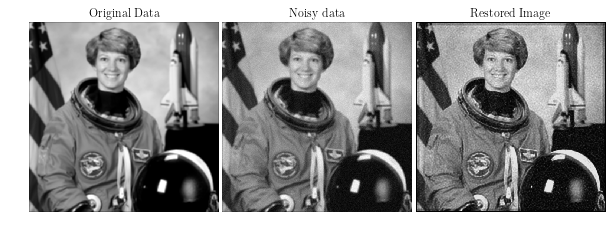

In [307]:


astro = color.rgb2gray(data.astronaut())

psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=30)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restored Image')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

In [46]:
def LinearKernel(size,dir='right'):
    kernel_motion_blur = np.zeros((2*size+1, 2*size+1))
    kernel_motion_blur[(size), (size)::] = np.ones(size+1)
    kernel_motion_blur[size,size] = 1
    kernel_motion_blur = kernel_motion_blur /(size + 1)
    if dir == 'right':
        return kernel_motion_blur
    else: 
        return np.flip(kernel_motion_blur)

In [47]:
X = LinearKernel(15,dir='right')

In [48]:
X

array([[0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.   

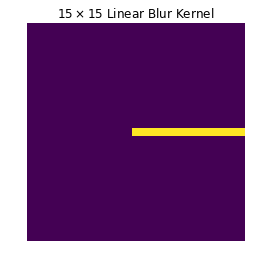

In [53]:
plt.imshow(X)
plt.axis('off')
plt.title(r'$15 \times 15$ Linear Blur Kernel')
plt.savefig('linear_kernel.eps',dpi=800)